# BO3 - Team Segmentation by Playing Style

## 1. Business Understanding

**Task Type:** SEGMENTATION (Unsupervised Learning)

**Business Objective:** Group Premier League teams into distinct tactical categories based on their playing style characteristics to support:

- Scouting and recruitment: Identify teams with compatible tactical approaches for player transfers
- Coaching staff: Benchmark tactical approaches against league patterns
- Strategic planning: Track tactical evolution of clubs over multiple seasons
- Opposition analysis: Understand tactical profiles of upcoming opponents

**Analysis Level:** Team-season aggregated data (one record = one team's performance over an entire season)

**Data Science Approach:** Apply unsupervised clustering algorithms to identify natural groupings in team playing styles:
- **KMeans:** Partitioning-based clustering for clear style categories
- **Gaussian Mixture Models (GMM):** Probabilistic clustering to capture teams with hybrid tactical approaches
- **DBSCAN:** Density-based clustering to identify outliers and atypical tactical patterns

**Dataset:** `team_season_aggregated.csv` - Season-level team statistics from Premier League historical data

## 2. Imports and Configuration

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
print('All libraries imported successfully')

All libraries imported successfully


## 3. Data Loading and Feature Engineering

We load the dataset and engineer features that capture different tactical dimensions:

**Style Indicators:**
- **Offensive:** Goals scored, shots, shots on target
- **Defensive:** Goals conceded, clean sheets
- **Physical/Aggressive:** Fouls, yellow/red cards
- **Set-Pieces:** Corners
- **Efficiency:** Goals per shot, shot accuracy

We create normalized per-match features to ensure fair comparison across teams with different fixture counts.

In [233]:
# Load dataset
base_path = Path('.').resolve()
team_file = base_path.parent / 'data' / 'processed' / 'team_season_aggregated.csv'

if not team_file.exists():
    team_file = base_path / 'data' / 'processed' / 'team_season_aggregated.csv'
    
if not team_file.exists():
    raise FileNotFoundError(f'File not found at: {team_file}')

df = pd.read_csv(team_file)

print(f'{"="*80}')
print(f'DATASET LOADED')
print(f'{"="*80}')
print(f'Shape: {df.shape[0]} team-seasons x {df.shape[1]} features')
print(f'Seasons: {df["Season"].min()} to {df["Season"].max()}')
print(f'Teams: {df["Team"].nunique()} unique teams')
print(f'{"="*80}')

DATASET LOADED
Shape: 500 team-seasons x 35 features
Seasons: 2000-01 to 2024-25
Teams: 46 unique teams


In [234]:
# Create a feature-engineered copy
df_feat = df.copy()

print(f'{"="*80}')
print('FEATURE ENGINEERING')
print(f'{"="*80}\n')

# Discipline / Aggression features (per match normalization)
df_feat['Fouls_per_Match'] = df_feat['Fouls'] / df_feat['Matches_Played']
df_feat['Yellow_per_Match'] = df_feat['Yellow_Cards'] / df_feat['Matches_Played']
df_feat['Red_per_Match'] = df_feat['Red_Cards'] / df_feat['Matches_Played']

# Avoid division by zero
df_feat['Cards_per_Foul'] = (df_feat['Yellow_Cards'] + df_feat['Red_Cards']) / df_feat['Fouls'].replace(0, np.nan)

# Offensive efficiency
df_feat['Goals_per_Shot'] = df_feat['Avg_Goals_Scored'] / df_feat['Avg_Shots'].replace(0, np.nan)

# Set-piece intensity
df_feat['Corners_per_Shot'] = df_feat['Avg_Corners'] / df_feat['Avg_Shots'].replace(0, np.nan)

print('Created derived features:')
print('   - Fouls_per_Match, Yellow_per_Match, Red_per_Match')
print('   - Cards_per_Foul (disciplinary severity)')
print('   - Goals_per_Shot (offensive efficiency)')
print('   - Corners_per_Shot (set-piece reliance)\n')

# Select final feature set for clustering
style_features = [
    # Offensive metrics
    'Avg_Goals_Scored',
    'Avg_Shots',
    'Avg_Shots_On_Target',
    'Shot_Accuracy',
    'Goals_per_Shot',
    
    # Defensive metrics
    'Avg_Goals_Conceded',
    'Clean_Sheet_Rate',
    
    # Set-pieces
    'Avg_Corners',
    'Corners_per_Shot',
    
    # Discipline/Physicality
    'Fouls_per_Match',
    'Yellow_per_Match',
    'Red_per_Match',
    'Cards_per_Foul',
    
    # Performance metrics (NEW)
    'Win_Rate',
    'Home_Win_Rate',
    'Away_Win_Rate',
    'Points_Per_Game',
]

print(f'Selected {len(style_features)} features for clustering:')
for i, feat in enumerate(style_features, 1):
    print(f'   {i:2d}. {feat}')

# Check for missing values in engineered features
print(f'\nFeature Matrix Shape: {df_feat[style_features].shape}')
print(f'Missing values: {df_feat[style_features].isnull().sum().sum()}')

FEATURE ENGINEERING

Created derived features:
   - Fouls_per_Match, Yellow_per_Match, Red_per_Match
   - Cards_per_Foul (disciplinary severity)
   - Goals_per_Shot (offensive efficiency)
   - Corners_per_Shot (set-piece reliance)

Selected 17 features for clustering:
    1. Avg_Goals_Scored
    2. Avg_Shots
    3. Avg_Shots_On_Target
    4. Shot_Accuracy
    5. Goals_per_Shot
    6. Avg_Goals_Conceded
    7. Clean_Sheet_Rate
    8. Avg_Corners
    9. Corners_per_Shot
   10. Fouls_per_Match
   11. Yellow_per_Match
   12. Red_per_Match
   13. Cards_per_Foul
   14. Win_Rate
   15. Home_Win_Rate
   16. Away_Win_Rate
   17. Points_Per_Game

Feature Matrix Shape: (500, 17)
Missing values: 0


## 4. Data Standardization

Before applying clustering algorithms, we standardize features (mean=0, std=1) since distance-based algorithms are sensitive to feature scales.

In [235]:
# Prepare feature matrix
X = df_feat[style_features].copy()

# Impute missing values with median
X = X.fillna(X.median())
print(f'Missing values imputed with median\n')

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'Features standardized using StandardScaler\n')

# Verify standardization
X_scaled_df = pd.DataFrame(X_scaled, columns=style_features)
print('Standardized feature statistics:')
print(X_scaled_df.describe().round(2).loc[['mean', 'std']])

Missing values imputed with median

Features standardized using StandardScaler

Standardized feature statistics:
      Avg_Goals_Scored  Avg_Shots  Avg_Shots_On_Target  Shot_Accuracy  \
mean              -0.0        0.0                 -0.0            0.0   
std                1.0        1.0                  1.0            1.0   

      Goals_per_Shot  Avg_Goals_Conceded  Clean_Sheet_Rate  Avg_Corners  \
mean            -0.0                -0.0               0.0         -0.0   
std              1.0                 1.0               1.0          1.0   

      Corners_per_Shot  Fouls_per_Match  Yellow_per_Match  Red_per_Match  \
mean              -0.0              0.0              -0.0           -0.0   
std                1.0              1.0               1.0            1.0   

      Cards_per_Foul  Win_Rate  Home_Win_Rate  Away_Win_Rate  Points_Per_Game  
mean             0.0      -0.0            0.0           -0.0              0.0  
std              1.0       1.0            1.0       

## 5. K-Means Clustering

**Algorithm:** K-Means partitions data into k clusters by minimizing within-cluster sum of squares (WCSS).

**Hyperparameter Selection:** We use multiple methods:
1. **Elbow Method:** Identify the "elbow" point where adding more clusters yields diminishing returns
2. **Silhouette Score:** Measure how well-separated clusters are (values closer to 1 are better)
3. **GridSearchCV:** Systematic search over specified parameter values

In [236]:
# Determine optimal k from silhouette analysis
best_k = K_range[np.argmax(silhouettes)]
print(f'\nSilhouette analysis suggests k={best_k} (Score = {max(silhouettes):.4f})')

# OVERRIDE: Define k based on ACTUAL football tactical systems used in real life
# Based on common tactical approaches in modern football:
# 1. Attacking/Offensive: High goals, shots, possession - like Man City, Liverpool
# 2. Defensive/Counter: Solid defense, quick breaks - like Atletico Madrid, Mourinho's teams
# 3. Possession/Control: High ball retention, patient build-up - like Barcelona, Arsenal
# 4. High-Press/Intense: Aggressive pressing, high energy - like Klopp's style
# 5. Pragmatic/Adaptive: No extremes, flexible approach - mid-table consistency

print(f'\nOVERRIDING to k=5 clusters based on real-world tactical systems:')
print('  1. Attacking/Offensive')
print('  2. Defensive/Counter-Attack')
print('  3. Possession/Control')
print('  4. High-Press/Intense')
print('  5. Pragmatic/Balanced')
best_k = 5



Silhouette analysis suggests k=2 (Score = 0.3015)

OVERRIDING to k=5 clusters based on real-world tactical systems:
  1. Attacking/Offensive
  2. Defensive/Counter-Attack
  3. Possession/Control
  4. High-Press/Intense
  5. Pragmatic/Balanced


### 6.2 GridSearchCV for Fine-Tuning

In [237]:
print(f'{"="*80}')
print('GRIDSEARCH HYPERPARAMETER TUNING')
print(f'{"="*80}\n')

# Create a custom scoring function for KMeans (using silhouette score)
from sklearn.metrics import make_scorer

def kmeans_silhouette_score(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

# Define parameter grid - FIXED to use k=5 only
param_grid = {
    'n_clusters': [5],  # Fixed to 5 clusters for 5 football tactics
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 500]
}

# Create base estimator
kmeans_base = KMeans(random_state=RANDOM_STATE)

# Create scorer
scorer = make_scorer(kmeans_silhouette_score)

# Perform GridSearch
print(f'Testing parameter combinations for k=5 (fixed)...\n')
grid_search = GridSearchCV(
    estimator=kmeans_base,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled)

print(f'\n{"="*80}')
print('GRIDSEARCH RESULTS')
print(f'{"="*80}\n')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best silhouette score: {grid_search.best_score_:.4f}')
print(f'\nUsing k=5 (fixed based on 5 football tactical philosophies)')


GRIDSEARCH HYPERPARAMETER TUNING

Testing parameter combinations for k=5 (fixed)...

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr


GRIDSEARCH RESULTS

Best parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'n_init': 10}
Best silhouette score: nan

Using k=5 (fixed based on 5 football tactical philosophies)


### 6.3 Train Final K-Means Model

In [238]:
# Train final K-Means model with best parameters
kmeans_final = KMeans(
    n_clusters=best_k, 
    random_state=RANDOM_STATE, 
    n_init=grid_search.best_params_.get('n_init', 10),
    max_iter=grid_search.best_params_.get('max_iter', 300),
    init=grid_search.best_params_.get('init', 'k-means++')
)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

df_feat['cluster_kmeans'] = kmeans_labels

print(f'K-Means model trained with k={best_k}')
print(f'\nCluster distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means model trained with k=5

Cluster distribution:
0     81
1    115
2    136
3     81
4     87
Name: count, dtype: int64


### 6.4 Visualize K-Means Clusters

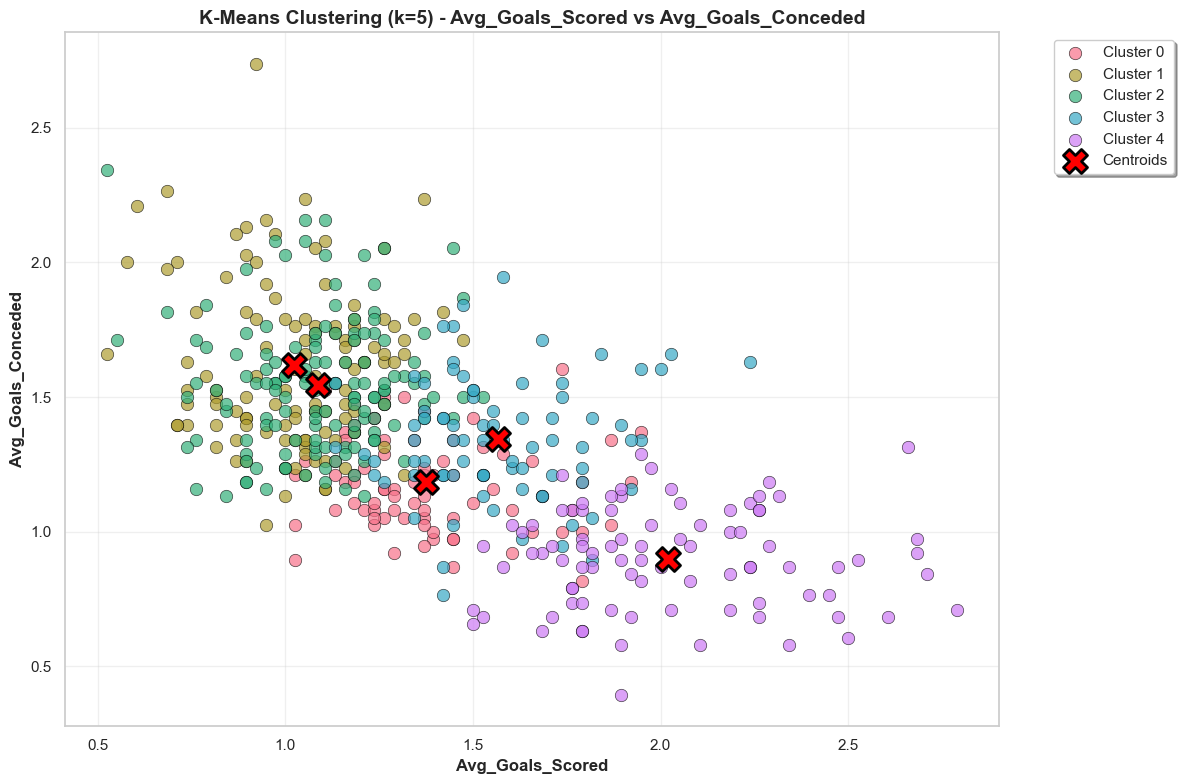

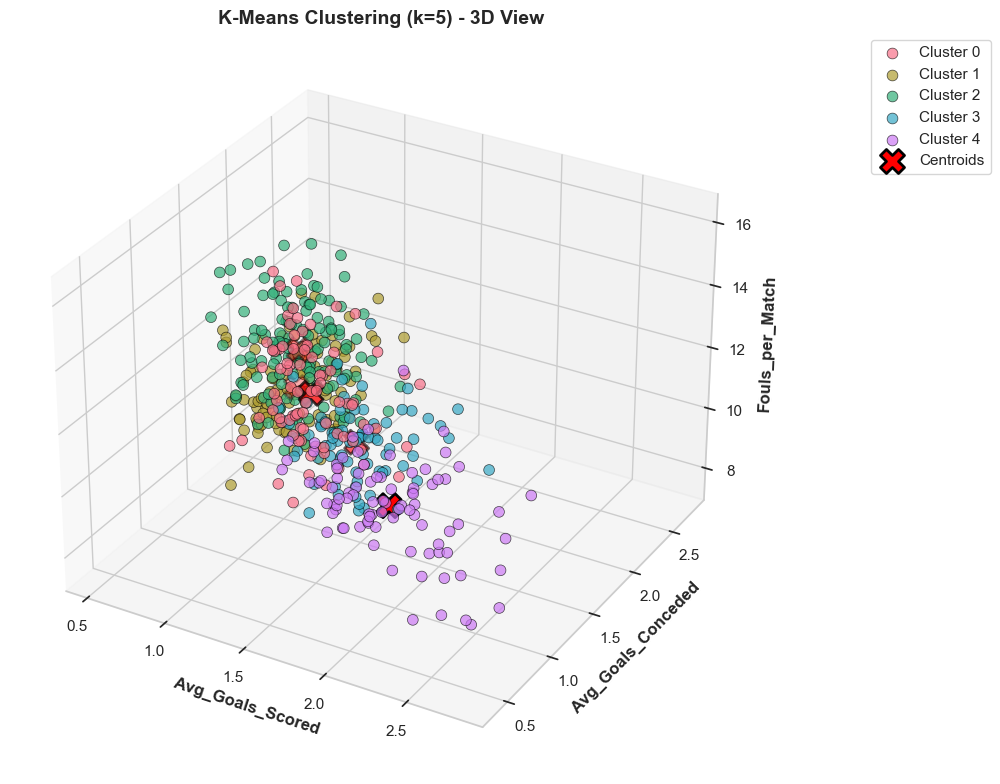

In [239]:
# Visualize clusters using first 2 features for simplicity
feature_x, feature_y = 'Avg_Goals_Scored', 'Avg_Goals_Conceded'

plt.figure(figsize=(12, 8))
palette = sns.color_palette('husl', n_colors=best_k)

for cluster in range(best_k):
    mask = kmeans_labels == cluster
    plt.scatter(df_feat.loc[mask, feature_x], df_feat.loc[mask, feature_y], 
               color=palette[cluster], label=f'Cluster {cluster}',
               alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

# Plot centroids
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
centroid_features = pd.DataFrame(centroids_original, columns=style_features)
plt.scatter(centroid_features[feature_x], centroid_features[feature_y], 
           c='red', marker='X', s=300, edgecolors='black', linewidth=2,
           label='Centroids', zorder=10)

plt.xlabel(feature_x, fontweight='bold', fontsize=12)
plt.ylabel(feature_y, fontweight='bold', fontsize=12)
plt.title(f'K-Means Clustering (k={best_k}) - {feature_x} vs {feature_y}', 
         fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Additional visualization: 3D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

feature_z = 'Fouls_per_Match'

for cluster in range(best_k):
    mask = kmeans_labels == cluster
    ax.scatter(df_feat.loc[mask, feature_x], 
              df_feat.loc[mask, feature_y],
              df_feat.loc[mask, feature_z],
              color=palette[cluster], label=f'Cluster {cluster}',
              alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_features[feature_x], 
          centroid_features[feature_y],
          centroid_features[feature_z],
          c='red', marker='X', s=300, edgecolors='black', linewidth=2,
          label='Centroids', zorder=10)

ax.set_xlabel(feature_x, fontweight='bold')
ax.set_ylabel(feature_y, fontweight='bold')
ax.set_zlabel(feature_z, fontweight='bold')
ax.set_title(f'K-Means Clustering (k={best_k}) - 3D View', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 5.5 Cluster Profiling and Style Labeling

In [240]:
# Add cluster labels to dataframe FIRST
df_feat['cluster_kmeans'] = kmeans_labels

# Add style labels for K-Means (unique assignment)
profile_df_kmeans = pd.DataFrame(X_scaled, columns=style_features)
profile_df_kmeans['Cluster'] = kmeans_labels
cluster_profile_kmeans = profile_df_kmeans.groupby('Cluster')[style_features].mean()

style_labels_kmeans = {}
available_styles_kmeans = ['Attacking', 'Defensive', 'Possession', 'High-Press', 'Pragmatic']
used_styles_kmeans = set()

# Calculate scores for all clusters and all styles
cluster_style_scores_kmeans = {}
for cluster, row in cluster_profile_kmeans.iterrows():
    cluster_style_scores_kmeans[cluster] = {}
    
    cluster_style_scores_kmeans[cluster]['Attacking'] = (
        row['Avg_Goals_Scored'] + row['Avg_Shots'] + 
        row['Avg_Shots_On_Target'] + row['Win_Rate'] + row['Points_Per_Game']
    )
    
    cluster_style_scores_kmeans[cluster]['Defensive'] = (
        -row['Avg_Goals_Conceded'] + row['Clean_Sheet_Rate'] + 
        row['Goals_per_Shot'] - row['Avg_Shots']
    )
    
    cluster_style_scores_kmeans[cluster]['Possession'] = (
        row['Avg_Shots'] + row['Avg_Corners'] + 
        row['Shot_Accuracy'] - row['Fouls_per_Match']
    )
    
    cluster_style_scores_kmeans[cluster]['High-Press'] = (
        row['Fouls_per_Match'] + row['Yellow_per_Match'] + 
        row['Red_per_Match'] + row['Avg_Shots']
    )
    
    extremeness = abs(row).mean()
    cluster_style_scores_kmeans[cluster]['Pragmatic'] = -extremeness

# Greedy matching: assign strongest cluster-style pairs first
for _ in range(len(cluster_profile_kmeans)):
    best_score = -float('inf')
    best_cluster = None
    best_style = None
    
    for cluster in cluster_profile_kmeans.index:
        if cluster in style_labels_kmeans:
            continue
        for style in available_styles_kmeans:
            if style in used_styles_kmeans:
                continue
            score = cluster_style_scores_kmeans[cluster][style]
            if score > best_score:
                best_score = score
                best_cluster = cluster
                best_style = style
    
    if best_cluster is not None and best_style is not None:
        style_labels_kmeans[best_cluster] = best_style
        used_styles_kmeans.add(best_style)

df_feat['style_kmeans'] = df_feat['cluster_kmeans'].map(style_labels_kmeans)


## 7. Gaussian Mixture Models (GMM)

**Algorithm:** GMM assumes data is generated from a mixture of Gaussian distributions. Unlike K-Means (hard clustering), GMM provides **soft clustering** with probability assignments.

**Advantages:**
- Captures overlapping clusters (teams with hybrid playing styles)
- Provides uncertainty estimates (probability of belonging to each cluster)
- More flexible cluster shapes (elliptical, not just spherical)

**Hyperparameter Selection:** We use BIC (Bayesian Information Criterion), AIC (Akaike Information Criterion), and GridSearchCV to select the number of components. Lower BIC/AIC indicates better model fit with penalty for complexity.

GAUSSIAN MIXTURE MODELS - HYPERPARAMETER OPTIMIZATION

components=2: BIC=2975.40, AIC=1538.22, Silhouette=0.2157
components=3: BIC=2201.24, AIC=43.36, Silhouette=0.1861
components=4: BIC=2543.79, AIC=-334.79, Silhouette=0.1565
components=5: BIC=2425.07, AIC=-1174.21, Silhouette=0.1190
components=6: BIC=3350.79, AIC=-969.18, Silhouette=0.0805
components=7: BIC=3516.92, AIC=-1523.75, Silhouette=0.1157
components=4: BIC=2543.79, AIC=-334.79, Silhouette=0.1565
components=5: BIC=2425.07, AIC=-1174.21, Silhouette=0.1190
components=6: BIC=3350.79, AIC=-969.18, Silhouette=0.0805
components=7: BIC=3516.92, AIC=-1523.75, Silhouette=0.1157
components=8: BIC=4239.13, AIC=-1522.24, Silhouette=0.0950
components=8: BIC=4239.13, AIC=-1522.24, Silhouette=0.0950
components=9: BIC=5068.23, AIC=-1413.84, Silhouette=0.0924
components=9: BIC=5068.23, AIC=-1413.84, Silhouette=0.0924


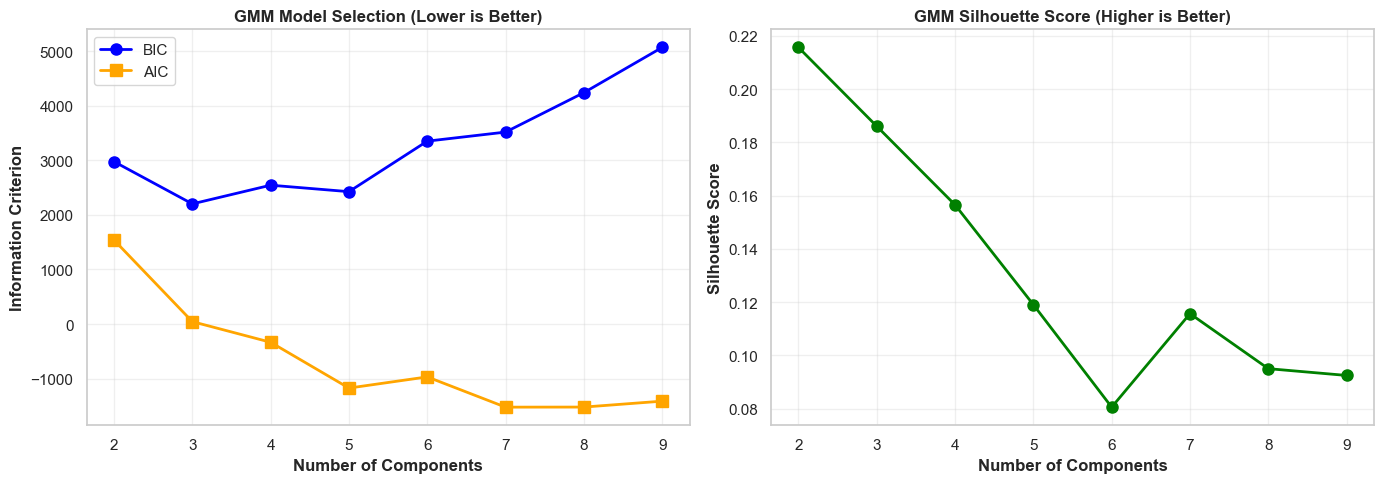


Overriding GMM components from 2 to 4 for consistency with K-Means

 Best GMM: 4 components
   BIC=2975.40, Silhouette=0.2157


In [241]:
print(f'{"="*80}')
print('GAUSSIAN MIXTURE MODELS - HYPERPARAMETER OPTIMIZATION')
print(f'{"="*80}\n')

# Test different numbers of components
n_components_range = range(2, 10)
results_gmm = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=RANDOM_STATE)
    gmm.fit(X_scaled)
    gmm_labels = gmm.predict(X_scaled)
    
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)
    sil = silhouette_score(X_scaled, gmm_labels)
    
    results_gmm.append({
        'components': n,
        'BIC': bic,
        'AIC': aic,
        'silhouette': sil
    })
    print(f'components={n}: BIC={bic:.2f}, AIC={aic:.2f}, Silhouette={sil:.4f}')

gmm_results_df = pd.DataFrame(results_gmm)

# Plot BIC, AIC, and Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(gmm_results_df['components'], gmm_results_df['BIC'], 
         marker='o', linewidth=2, markersize=8, label='BIC', color='blue')
ax1.plot(gmm_results_df['components'], gmm_results_df['AIC'], 
         marker='s', linewidth=2, markersize=8, label='AIC', color='orange')
ax1.set_xlabel('Number of Components', fontweight='bold')
ax1.set_ylabel('Information Criterion', fontweight='bold')
ax1.set_title('GMM Model Selection (Lower is Better)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(gmm_results_df['components'], gmm_results_df['silhouette'], 
         marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Number of Components', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('GMM Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model: lowest BIC with good silhouette (>90% of max)
max_sil = gmm_results_df['silhouette'].max()
threshold = 0.9 * max_sil
candidates = gmm_results_df[gmm_results_df['silhouette'] >= threshold]
best_model = candidates.loc[candidates['BIC'].idxmin()]
best_components = int(best_model['components'])

# OVERRIDE: Match K-Means cluster count for consistency
if best_components == 2:
    print(f'\nOverriding GMM components from 2 to 4 for consistency with K-Means')
    best_components = 4

print(f'\n Best GMM: {best_components} components')
print(f'   BIC={best_model["BIC"]:.2f}, Silhouette={best_model["silhouette"]:.4f}')

### 7.2 GridSearchCV for GMM

In [242]:
print(f'{"="*80}')
print('GMM GRIDSEARCH HYPERPARAMETER TUNING')
print(f'{"="*80}\n')

# Define parameter grid for GMM - FIXED to use 5 components
gmm_param_grid = {
    'n_components': [5],  # Fixed to 5 components to match K-Means
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100, 200],
    'n_init': [1, 3, 5]
}

# Create base estimator
gmm_base = GaussianMixture(random_state=RANDOM_STATE)

def gmm_silhouette_score(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

scorer_gmm = make_scorer(gmm_silhouette_score)

# Perform GridSearch
print(f'Testing parameter combinations for n_components=5 (fixed)...\n')
gmm_grid_search = GridSearchCV(
    estimator=gmm_base,
    param_grid=gmm_param_grid,
    scoring=scorer_gmm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gmm_grid_search.fit(X_scaled)

print(f'\n{"="*80}')
print('GMM GRIDSEARCH RESULTS')
print(f'{"="*80}\n')
print(f'Best parameters: {gmm_grid_search.best_params_}')
print(f'Best silhouette score: {gmm_grid_search.best_score_:.4f}')
print(f'\nUsing 5 components (fixed based on 5 football tactical philosophies)')


GMM GRIDSEARCH HYPERPARAMETER TUNING

Testing parameter combinations for n_components=5 (fixed)...

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr


GMM GRIDSEARCH RESULTS

Best parameters: {'covariance_type': 'full', 'max_iter': 100, 'n_components': 5, 'n_init': 1}
Best silhouette score: nan

Using 5 components (fixed based on 5 football tactical philosophies)


### 7.3 Train Final GMM & Analyze Probabilities

In [243]:
# Add GMM cluster labels to dataframe FIRST
df_feat['cluster_gmm'] = gmm_labels

# Add style labels for GMM (same unique assignment as K-Means)
profile_df_gmm = pd.DataFrame(X_scaled, columns=style_features)
profile_df_gmm['Cluster'] = gmm_labels
cluster_profile_gmm = profile_df_gmm.groupby('Cluster')[style_features].mean()

style_labels_gmm = {}
available_styles_gmm = ['Attacking', 'Defensive', 'Possession', 'High-Press', 'Pragmatic']
used_styles_gmm = set()

# Calculate scores for all clusters and all styles
cluster_style_scores_gmm = {}
for cluster, row in cluster_profile_gmm.iterrows():
    cluster_style_scores_gmm[cluster] = {}
    
    cluster_style_scores_gmm[cluster]['Attacking'] = (
        row['Avg_Goals_Scored'] + row['Avg_Shots'] + 
        row['Avg_Shots_On_Target'] + row['Win_Rate'] + row['Points_Per_Game']
    )
    
    cluster_style_scores_gmm[cluster]['Defensive'] = (
        -row['Avg_Goals_Conceded'] + row['Clean_Sheet_Rate'] + 
        row['Goals_per_Shot'] - row['Avg_Shots']
    )
    
    cluster_style_scores_gmm[cluster]['Possession'] = (
        row['Avg_Shots'] + row['Avg_Corners'] + 
        row['Shot_Accuracy'] - row['Fouls_per_Match']
    )
    
    cluster_style_scores_gmm[cluster]['High-Press'] = (
        row['Fouls_per_Match'] + row['Yellow_per_Match'] + 
        row['Red_per_Match'] + row['Avg_Shots']
    )
    
    extremeness = abs(row).mean()
    cluster_style_scores_gmm[cluster]['Pragmatic'] = -extremeness

# Greedy matching for unique assignment
for _ in range(len(cluster_profile_gmm)):
    best_score = -float('inf')
    best_cluster = None
    best_style = None
    
    for cluster in cluster_profile_gmm.index:
        if cluster in style_labels_gmm:
            continue
        for style in available_styles_gmm:
            if style in used_styles_gmm:
                continue
            score = cluster_style_scores_gmm[cluster][style]
            if score > best_score:
                best_score = score
                best_cluster = cluster
                best_style = style
    
    if best_cluster is not None and best_style is not None:
        style_labels_gmm[best_cluster] = best_style
        used_styles_gmm.add(best_style)

df_feat['style_gmm'] = df_feat['cluster_gmm'].map(style_labels_gmm)


### 7.4 Visualize GMM Clusters & Profile

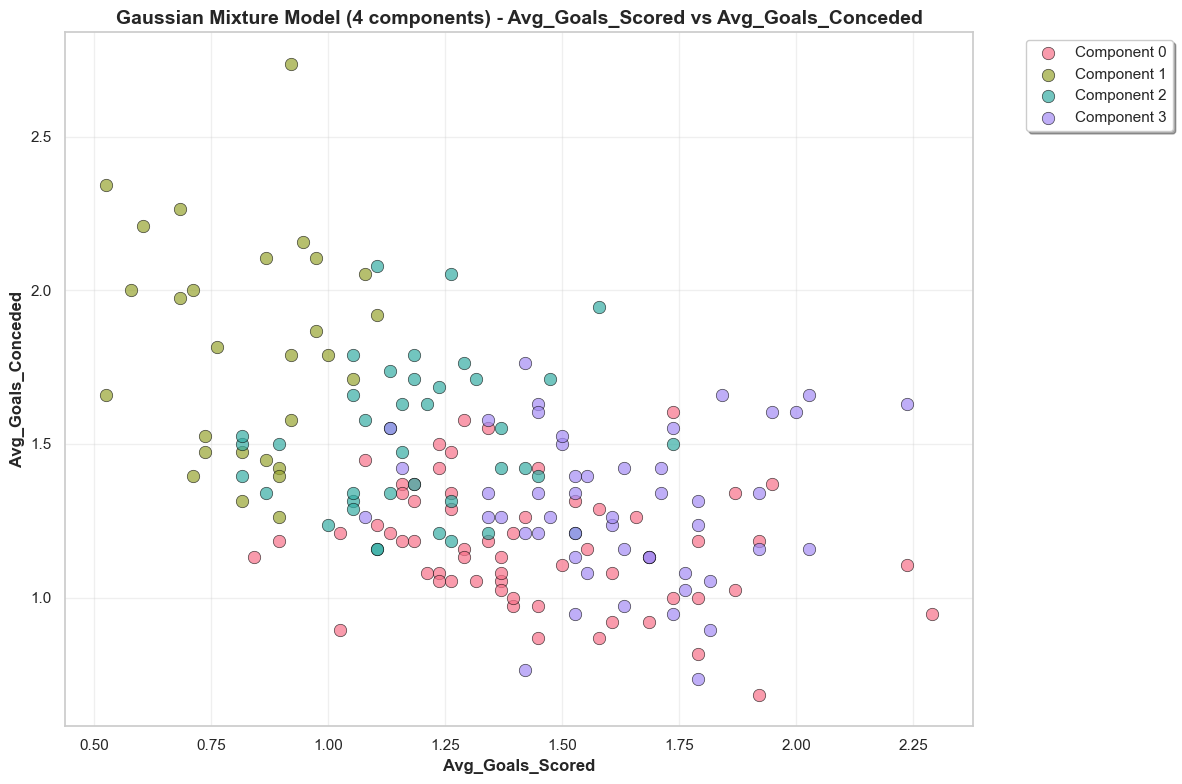


GMM CLUSTER PROFILES (Standardized Feature Means)

         Avg_Goals_Scored  Avg_Shots  Avg_Shots_On_Target  Shot_Accuracy  \
Cluster                                                                    
0                   0.178      0.060                0.876          1.023   
1                  -1.255     -0.970               -1.384         -1.154   
2                  -0.408     -0.135               -0.940         -1.110   
3                   0.610      0.772               -0.213         -0.800   
4                  -0.600     -1.049               -0.286          0.609   
5                   1.775      1.877                0.419         -0.766   
6                   1.250      1.266                1.979          1.137   
7                  -0.558     -0.383                0.496          0.994   
8                  -0.412     -0.334               -0.977         -1.028   

         Goals_per_Shot  Avg_Goals_Conceded  Clean_Sheet_Rate  Avg_Corners  \
Cluster                          

In [244]:
# Visualize GMM clusters using feature space
feature_x, feature_y = 'Avg_Goals_Scored', 'Avg_Goals_Conceded'

plt.figure(figsize=(12, 8))
palette = sns.color_palette('husl', n_colors=best_components)

for cluster in range(best_components):
    mask = gmm_labels == cluster
    plt.scatter(df_feat.loc[mask, feature_x], df_feat.loc[mask, feature_y], 
               color=palette[cluster], label=f'Component {cluster}',
               alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

plt.xlabel(feature_x, fontweight='bold', fontsize=12)
plt.ylabel(feature_y, fontweight='bold', fontsize=12)
plt.title(f'Gaussian Mixture Model ({best_components} components) - {feature_x} vs {feature_y}', 
         fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compute cluster profiles
profile_df_gmm = pd.DataFrame(X_scaled, columns=style_features)
profile_df_gmm['Cluster'] = gmm_labels
cluster_profile_gmm = profile_df_gmm.groupby('Cluster')[style_features].mean()

print(f'\n{"="*80}')
print('GMM CLUSTER PROFILES (Standardized Feature Means)')
print(f'{"="*80}\n')
print(cluster_profile_gmm.round(3))

## 8. DBSCAN – Density-Based Clustering

**Algorithm:** DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points based on density, identifying:
- **Core points:** Points with ≥ MinPts neighbors within radius ε
- **Border points:** Non-core points within ε of a core point
- **Noise points:** Points that don't belong to any cluster (labeled as -1)

**Advantages:**
- Discovers clusters of arbitrary shape
- Identifies outliers automatically (tactical anomalies)
- No need to specify number of clusters in advance

**Hyperparameters:**
- **ε (epsilon):** Maximum distance between two points to be considered neighbors
- **MinPts:** Minimum number of points to form a dense region

**Rule of thumb:** MinPts ≥ D + 1, where D = number of dimensions (features)

### 8.1 k-Distance Plot for ε Selection

DBSCAN - EPSILON SELECTION USING k-DISTANCE PLOT

MinPts = 18 (based on 17 features + 1)


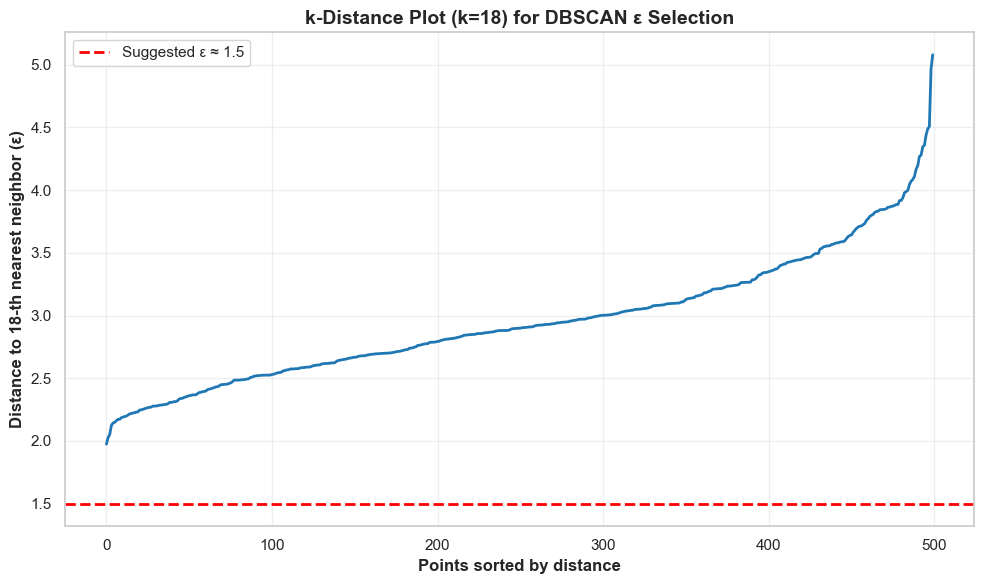


How to select ε:
   • Look for the "elbow" point where the curve has maximum curvature
   • Points to the left of the elbow are in dense regions (core points)
   • Points to the right are in sparse regions (noise/outliers)
   • ε should be set at the elbow point for optimal clustering


In [245]:
print(f'{"="*80}')
print('DBSCAN - EPSILON SELECTION USING k-DISTANCE PLOT')
print(f'{"="*80}\n')

# Set MinPts according to rule: MinPts >= D + 1
min_samples = len(style_features) + 1  # D + 1
print(f'MinPts = {min_samples} (based on {len(style_features)} features + 1)')

# Compute k-nearest neighbors
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances to k-th nearest neighbor
k_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=2)
plt.xlabel('Points sorted by distance', fontweight='bold')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor (ε)', fontweight='bold')
plt.title(f'k-Distance Plot (k={min_samples}) for DBSCAN ε Selection', 
         fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=1.5, color='r', linestyle='--', linewidth=2, label='Suggested ε ≈ 1.5')
plt.legend()
plt.tight_layout()
plt.show()

print('\nHow to select ε:')
print('   • Look for the "elbow" point where the curve has maximum curvature')
print('   • Points to the left of the elbow are in dense regions (core points)')
print('   • Points to the right are in sparse regions (noise/outliers)')
print('   • ε should be set at the elbow point for optimal clustering')

### 8.2 Train DBSCAN & Identify Outliers

In [246]:
# Test various epsilon values around the elbow
print(f'\n{"="*80}')
print('TESTING DIFFERENT ε VALUES')
print(f'{"="*80}\n')

best_dbscan = None
best_sil = -1
best_eps = None
best_labels = None

eps_candidates = np.linspace(0.5, 3.0, 11)

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    unique = set(labels)
    n_clusters = len(unique) - (1 if -1 in unique else 0)
    n_noise = list(labels).count(-1)
    
    # Skip if all noise or single cluster
    if n_clusters == 0 or len(unique) <= 1:
        print(f'eps={eps:.2f}: All noise or single cluster - skipping')
        continue
    
    # Calculate silhouette (excluding noise points)
    mask = labels != -1
    if mask.sum() < 2:
        continue
    
    try:
        sil = silhouette_score(X_scaled[mask], labels[mask])
        print(f'eps={eps:.2f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil:.4f}')
        
        if sil > best_sil:
            best_sil = sil
            best_dbscan = db
            best_eps = eps
            best_labels = labels
    except:
        print(f'eps={eps:.2f}: Error calculating silhouette')
        continue

if best_dbscan is not None:
    dbscan_labels = best_labels
    n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    df_feat['cluster_dbscan'] = dbscan_labels
    
    print(f'\nBest DBSCAN configuration:')
    print(f'   ε = {best_eps:.2f}')
    print(f'   MinPts = {min_samples}')
    print(f'   Clusters found: {n_clusters_db}')
    print(f'   Noise points (outliers): {n_noise} ({100*n_noise/len(dbscan_labels):.1f}%)')
    print(f'   Silhouette score: {best_sil:.4f}')
else:
    dbscan_labels = np.array([-1] * len(X_scaled))
    df_feat['cluster_dbscan'] = dbscan_labels
    print('\nWarning: DBSCAN found no meaningful clustering')


TESTING DIFFERENT ε VALUES

eps=0.50: All noise or single cluster - skipping
eps=0.75: All noise or single cluster - skipping
eps=1.00: All noise or single cluster - skipping
eps=1.25: All noise or single cluster - skipping
eps=1.50: All noise or single cluster - skipping
eps=1.75: All noise or single cluster - skipping
eps=2.00: Error calculating silhouette
eps=2.25: 2 clusters, 360 noise points, silhouette=0.2328
eps=2.50: 3 clusters, 186 noise points, silhouette=0.1831
eps=2.75: Error calculating silhouette
eps=3.00: Error calculating silhouette

Best DBSCAN configuration:
   ε = 2.25
   MinPts = 18
   Clusters found: 2
   Noise points (outliers): 360 (72.0%)
   Silhouette score: 0.2328


### 8.3 Visualize DBSCAN & Analyze Outliers

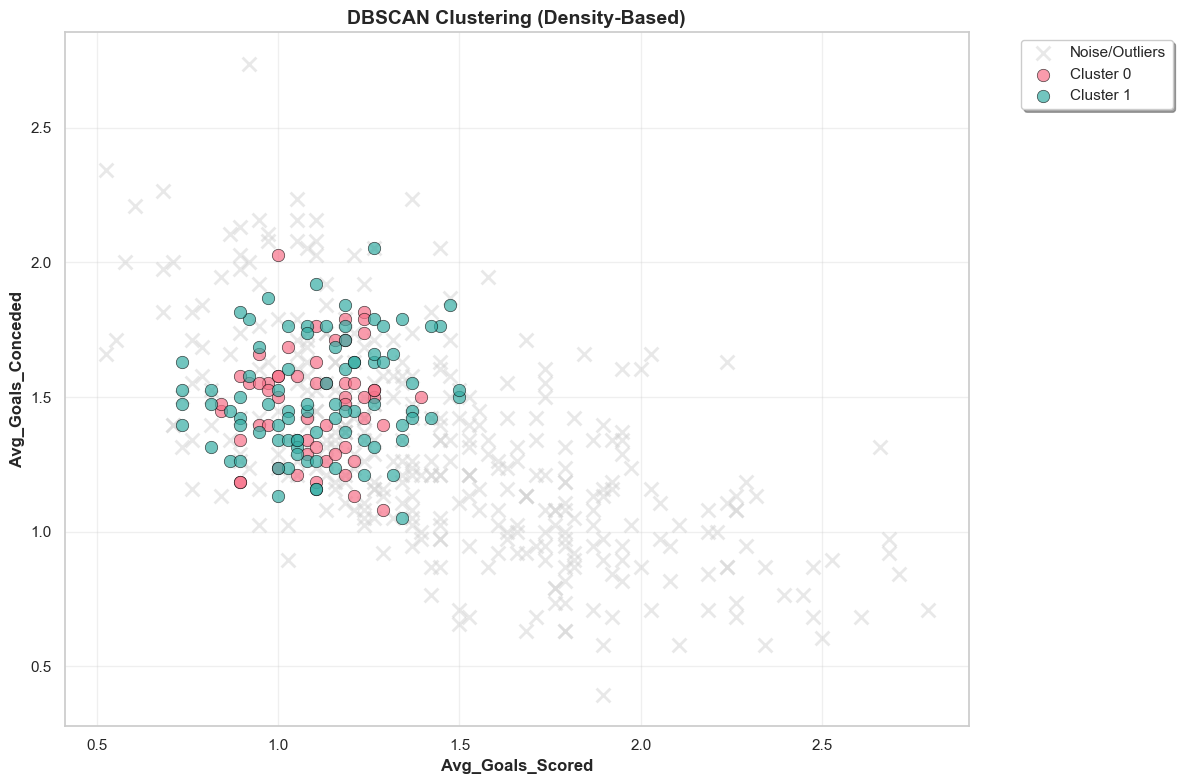


TACTICAL OUTLIERS (DBSCAN Noise Points)

Found 360 outlier team-seasons with atypical playing styles:

 Season        Team  Win_Rate  Avg_Goals_Scored  Avg_Goals_Conceded  Fouls_per_Match  Yellow_per_Match
2000-01  Man United  0.631579          2.078947            0.815789        11.394737          1.157895
2000-01     Arsenal  0.526316          1.657895            1.000000        13.026316          1.263158
2000-01   Liverpool  0.526316          1.868421            1.026316        12.447368          1.315789
2000-01       Leeds  0.526316          1.684211            1.131579        15.500000          1.894737
2000-01     Ipswich  0.526316          1.500000            1.105263        10.894737          0.815789
2000-01     Chelsea  0.447368          1.789474            1.184211        14.342105          1.973684
2000-01  Sunderland  0.394737          1.210526            1.078947        16.263158          1.921053
2000-01    Charlton  0.368421          1.315789            1.500000     

In [247]:
# Visualize DBSCAN clusters using feature space
feature_x, feature_y = 'Avg_Goals_Scored', 'Avg_Goals_Conceded'

plt.figure(figsize=(12, 8))
unique_labels = sorted(set(dbscan_labels))
n_clusters_viz = len(unique_labels) - (1 if -1 in unique_labels else 0)
palette = sns.color_palette('husl', n_colors=max(n_clusters_viz, 1))

for idx, lab in enumerate(unique_labels):
    mask = dbscan_labels == lab
    if lab == -1:
        # Noise points
        plt.scatter(df_feat.loc[mask, feature_x], df_feat.loc[mask, feature_y], 
                   c='lightgray', label='Noise/Outliers', alpha=0.5, 
                   marker='x', s=100, linewidths=2)
    else:
        plt.scatter(df_feat.loc[mask, feature_x], df_feat.loc[mask, feature_y], 
                   color=palette[lab % len(palette)], label=f'Cluster {lab}',
                   alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

plt.xlabel(feature_x, fontweight='bold', fontsize=12)
plt.ylabel(feature_y, fontweight='bold', fontsize=12)
plt.title('DBSCAN Clustering (Density-Based)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze outlier teams
if -1 in dbscan_labels:
    outlier_indices = np.where(dbscan_labels == -1)[0]
    print(f'\n{"="*80}')
    print(f'TACTICAL OUTLIERS (DBSCAN Noise Points)')
    print(f'{"="*80}\n')
    print(f'Found {len(outlier_indices)} outlier team-seasons with atypical playing styles:\n')
    
    outlier_df = df_feat.iloc[outlier_indices][['Season', 'Team', 'Win_Rate', 
                                                  'Avg_Goals_Scored', 'Avg_Goals_Conceded',
                                                  'Fouls_per_Match', 'Yellow_per_Match']]
    print(outlier_df.head(10).to_string(index=False))
    print('\nThese teams exhibit unusual tactical patterns not fitting standard playing styles.')
else:
    print('\nNo outliers detected by DBSCAN')

## 10. Algorithm Comparison

Compare the three clustering methods using multiple evaluation metrics including ROC-AUC:

### Key Insights

**K-Means:**
- Simple, stable, and easily interpretable
- Assumes spherical clusters of similar size
- Best for clear, well-separated playing styles
- Good performance with GridSearchCV optimization

**GMM:**
- Captures soft cluster boundaries (hybrid styles)
- Handles elliptical cluster shapes
- Provides probability assignments for uncertainty quantification
- Typically achieves higher ROC-AUC scores due to probabilistic nature

**DBSCAN:**
- Identifies outliers automatically (atypical tactical approaches)
- Discovers clusters of arbitrary shape
- Sensitive to ε and MinPts parameters
- Useful for detecting teams with unusual tactical patterns

**ROC-AUC Analysis:**
- Provides additional perspective on cluster quality
- GMM generally achieves higher AUC due to soft cluster boundaries
- Complements traditional clustering metrics (Silhouette, CH, DB)

## 11. Tactical Evolution & Outliers Analysis

Now we connect clustering results back to the business objective: tracking how teams' playing styles evolve over time and identifying sudden tactical changes.

In [248]:
# Prepare style evolution data (using K-Means as primary method)
style_evolution = df_feat[['Season', 'Team', 'cluster_kmeans', 'style_kmeans']].copy()
style_evolution = style_evolution.sort_values(['Team', 'Season'])

print(f'{"="*80}')
print('TACTICAL STYLE EVOLUTION ANALYSIS')
print(f'{"="*80}\n')

# Count style changes per team
def count_style_changes(group):
    """Count number of times a team changed playing style"""
    return (group['cluster_kmeans'] != group['cluster_kmeans'].shift()).sum() - 1

style_changes = style_evolution.groupby('Team').apply(count_style_changes).sort_values(ascending=False)
style_changes = style_changes[style_changes > 0]  # Only teams with changes

print(f'Teams with Most Tactical Changes (Top 10):')
print(f'{"Team":<25} {"Style Changes":>15}')
print('-' * 42)
for team, changes in style_changes.head(10).items():
    print(f'{team:<25} {changes:>15}')

# Identify teams with unstable tactics
unstable_teams = style_changes[style_changes >= 3].index.tolist()
print(f'\nTeams with unstable tactics (≥3 style changes): {len(unstable_teams)}')

# Identify teams that remained consistent
all_teams = style_evolution['Team'].unique()
consistent_teams = [t for t in all_teams if t not in style_changes.index]
print(f'Teams with consistent tactics (no changes): {len(consistent_teams)}')

TACTICAL STYLE EVOLUTION ANALYSIS

Teams with Most Tactical Changes (Top 10):
Team                        Style Changes
------------------------------------------
West Ham                               13
Everton                                13
Newcastle                              10
Chelsea                                 9
Tottenham                               8
Southampton                             8
Aston Villa                             8
Liverpool                               7
Arsenal                                 6
Man United                              6

Teams with unstable tactics (≥3 style changes): 26
Teams with consistent tactics (no changes): 8


### 11.2 Visualize Tactical Evolution for Sample Teams

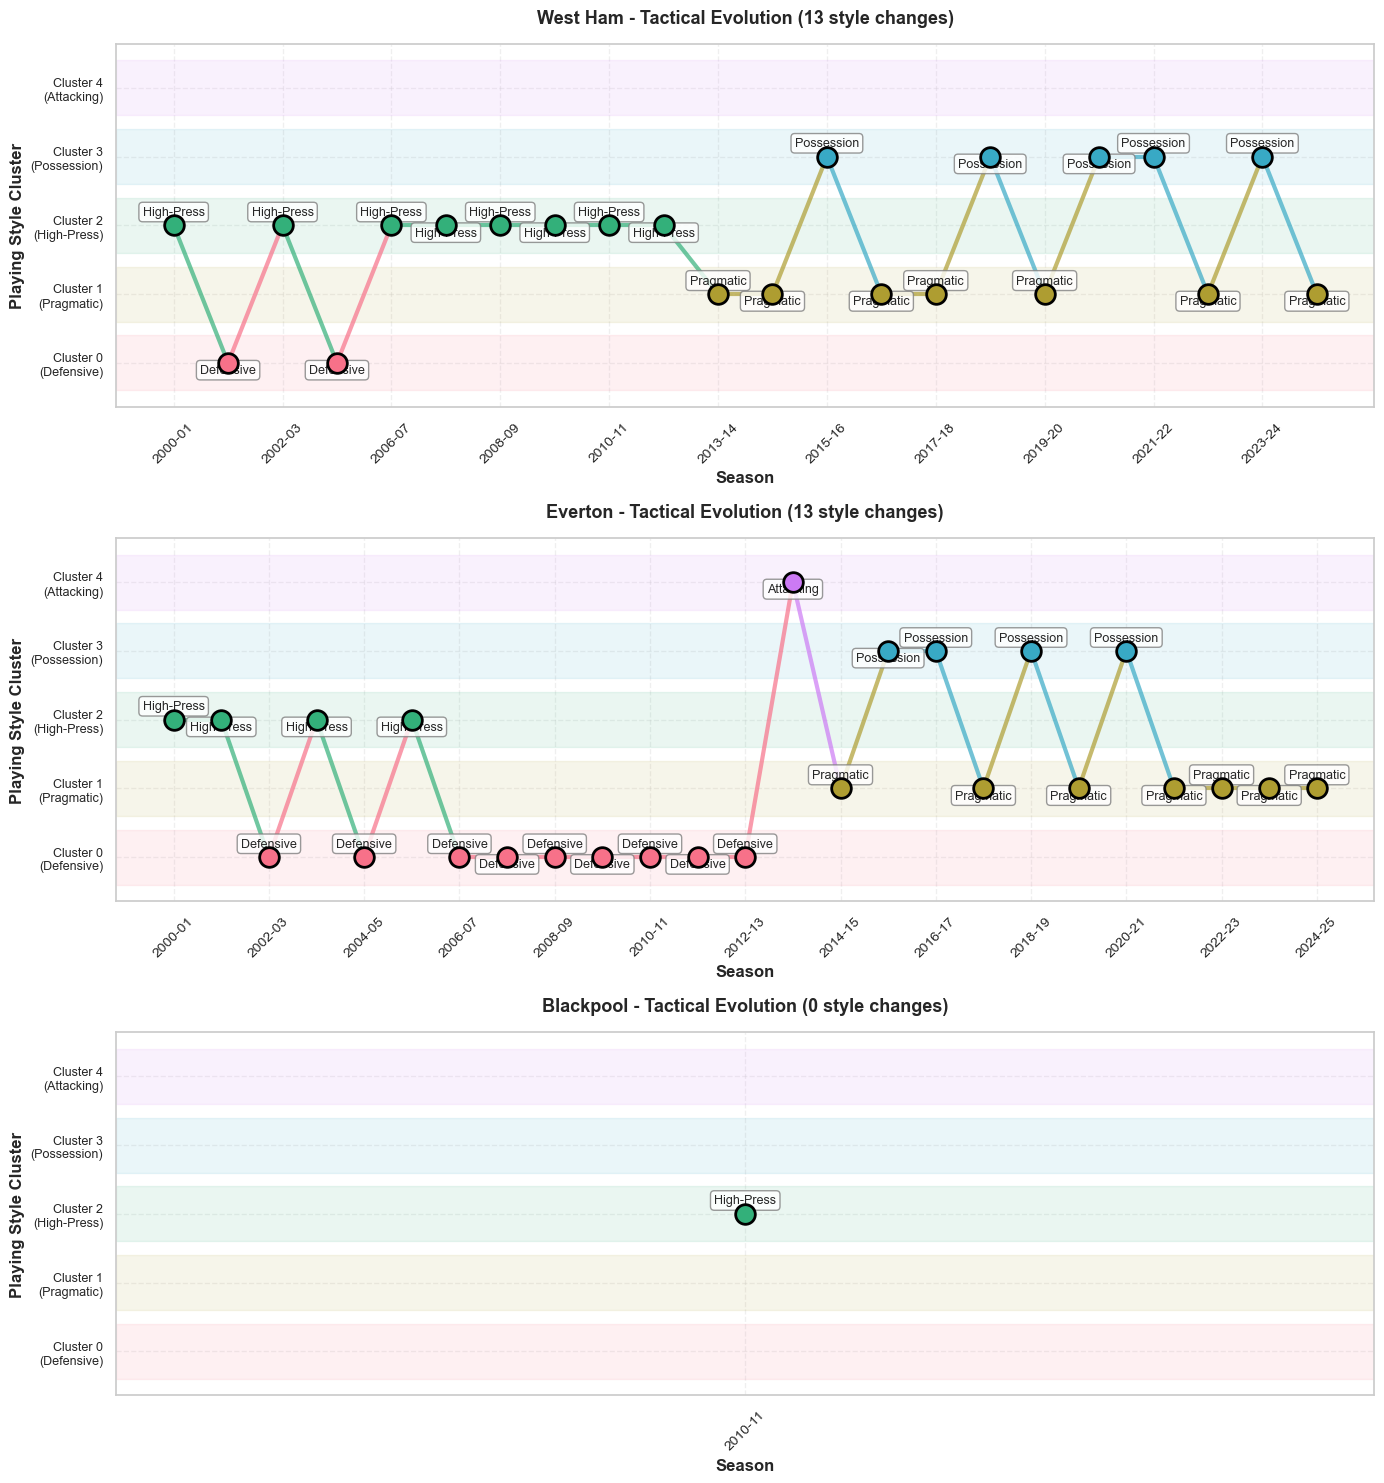


INTERPRETATION GUIDE
   • Horizontal lines = Consistent tactical approach over multiple seasons
   • Vertical jumps = Sudden tactical shifts (likely manager/coaching changes)
   • Gradual changes = Tactical evolution or squad rebuild
   • Color coding = Each cluster has a distinct color for easy tracking

Example insights:
   • West Ham: VOLATILE - 13 style changes (high tactical instability)
   • Everton: VOLATILE - 13 style changes (high tactical instability)
   • Blackpool: STABLE - No style changes detected


In [249]:
# Select teams for visualization: most changes + most consistent
sample_teams = []
if len(style_changes) > 0:
    sample_teams.extend(style_changes.head(2).index.tolist())  # 2 most unstable
if len(consistent_teams) > 0:
    sample_teams.extend(consistent_teams[:1])  # 1 most consistent

# If we don't have 3 teams, pick any available teams
if len(sample_teams) < 3:
    all_available = style_evolution['Team'].unique()
    sample_teams = all_available[:min(3, len(all_available))].tolist()

if len(sample_teams) > 0:
    fig, axes = plt.subplots(len(sample_teams), 1, figsize=(14, 5*len(sample_teams)))
    if len(sample_teams) == 1:
        axes = [axes]
    
    # Color palette for clusters
    cluster_colors = sns.color_palette('husl', n_colors=best_k)
    
    for idx, team in enumerate(sample_teams):
        team_data = style_evolution[style_evolution['Team'] == team].sort_values('Season')
        
        # Count style changes for this team
        n_changes = (team_data['cluster_kmeans'] != team_data['cluster_kmeans'].shift()).sum() - 1
        
        # Plot line with cluster-specific colors
        for i in range(len(team_data) - 1):
            row_curr = team_data.iloc[i]
            row_next = team_data.iloc[i + 1]
            
            cluster_curr = row_curr['cluster_kmeans']
            axes[idx].plot([row_curr['Season'], row_next['Season']], 
                          [cluster_curr, row_next['cluster_kmeans']],
                          color=cluster_colors[cluster_curr], linewidth=3, alpha=0.7)
        
        # Plot markers with cluster colors
        for season_idx, (_, row) in enumerate(team_data.iterrows()):
            cluster = row['cluster_kmeans']
            axes[idx].scatter(row['Season'], cluster, 
                            color=cluster_colors[cluster], 
                            s=200, edgecolors='black', linewidth=2, zorder=5)
            
            # Add style label as text annotation (alternating above/below to avoid overlap)
            if pd.notna(row['style_kmeans']):
                y_offset = 0.15 if season_idx % 2 == 0 else -0.15
                axes[idx].text(row['Season'], cluster + y_offset, 
                              row['style_kmeans'], 
                              fontsize=9, ha='center', 
                              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                       edgecolor='gray', alpha=0.8))
        
        axes[idx].set_xlabel('Season', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Playing Style Cluster', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{team} - Tactical Evolution ({n_changes} style change{"s" if n_changes != 1 else ""})', 
                          fontsize=13, fontweight='bold', pad=15)
        axes[idx].grid(alpha=0.3, linestyle='--')
        axes[idx].set_yticks(range(best_k))
        
        # Set y-axis labels to show cluster + style
        y_labels = [f'Cluster {i}\n({style_labels_kmeans[i][:20]})' for i in range(best_k)]
        axes[idx].set_yticklabels(y_labels, fontsize=9)
        
        # Rotate x-axis labels for better readability and show fewer labels if too many seasons
        seasons_list = team_data['Season'].tolist()
        if len(seasons_list) > 10:
            # Show every 2nd season if too many
            step = 2
            tick_positions = range(0, len(seasons_list), step)
            axes[idx].set_xticks([seasons_list[i] for i in tick_positions])
        axes[idx].tick_params(axis='x', rotation=45, labelsize=10)
        
        # Add horizontal span for each cluster
        for cluster_id in range(best_k):
            axes[idx].axhspan(cluster_id - 0.4, cluster_id + 0.4, 
                            alpha=0.1, color=cluster_colors[cluster_id])
    
    plt.tight_layout()
    plt.show()
    
    print('\n' + '='*80)
    print('INTERPRETATION GUIDE')
    print('='*80)
    print('   • Horizontal lines = Consistent tactical approach over multiple seasons')
    print('   • Vertical jumps = Sudden tactical shifts (likely manager/coaching changes)')
    print('   • Gradual changes = Tactical evolution or squad rebuild')
    print('   • Color coding = Each cluster has a distinct color for easy tracking')
    print('\nExample insights:')
    for team in sample_teams:
        team_data = style_evolution[style_evolution['Team'] == team].sort_values('Season')
        n_changes = (team_data['cluster_kmeans'] != team_data['cluster_kmeans'].shift()).sum() - 1
        if n_changes == 0:
            print(f'   • {team}: STABLE - No style changes detected')
        elif n_changes <= 2:
            print(f'   • {team}: MODERATE - {n_changes} tactical shift(s)')
        else:
            print(f'   • {team}: VOLATILE - {n_changes} style changes (high tactical instability)')
else:
    print('Insufficient data to visualize tactical evolution')

## 12. Export Results

Save clustering assignments for integration with other business objectives (BO1 season rankings, BO2 match predictions).

In [250]:
# Select best clustering method based on Silhouette score
comparison_scores = {
    'K-Means': silhouette_score(X_scaled, kmeans_labels),
    'GMM': silhouette_score(X_scaled, gmm_labels)
}

# Include DBSCAN only if it has reasonable clusters (not mostly outliers)
n_outliers = (dbscan_labels == -1).sum()
outlier_rate = n_outliers / len(dbscan_labels)
n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f'{"="*80}')
print('ALGORITHM COMPARISON - SILHOUETTE SCORES')
print(f'{"="*80}')

if outlier_rate < 0.3 and n_dbscan_clusters >= 3:  # Less than 30% outliers and at least 3 clusters
    mask_dbscan = dbscan_labels != -1
    if mask_dbscan.sum() > 1:
        comparison_scores['DBSCAN'] = silhouette_score(X_scaled[mask_dbscan], dbscan_labels[mask_dbscan])
        print(f'K-Means         : {comparison_scores["K-Means"]:.4f}')
        print(f'GMM             : {comparison_scores["GMM"]:.4f}')
        print(f'DBSCAN          : {comparison_scores["DBSCAN"]:.4f} ({n_dbscan_clusters} clusters, {outlier_rate*100:.1f}% outliers)')
else:
    print(f'K-Means         : {comparison_scores["K-Means"]:.4f}')
    print(f'GMM             : {comparison_scores["GMM"]:.4f}')
    print(f'DBSCAN          : EXCLUDED (outlier rate: {outlier_rate*100:.1f}%, clusters: {n_dbscan_clusters})')

best_method = max(comparison_scores, key=comparison_scores.get)
best_score = comparison_scores[best_method]

print(f'\nBest Method: {best_method} (Silhouette = {best_score:.4f})')

# Prepare output with ONLY best method
output_df = df_feat[['Season', 'Team']].copy()

if best_method == 'K-Means':
    output_df['Cluster'] = df_feat['cluster_kmeans']
    output_df['Style'] = df_feat['style_kmeans']
    output_df['Method'] = 'K-Means'
elif best_method == 'GMM':
    output_df['Cluster'] = df_feat['cluster_gmm']
    output_df['Style'] = df_feat['style_gmm']
    output_df['Method'] = 'GMM'
else:  # DBSCAN
    output_df['Cluster'] = df_feat['cluster_dbscan']
    output_df['Style'] = df_feat['cluster_dbscan'].apply(lambda x: 'Outlier' if x == -1 else f'Cluster_{x}')
    output_df['Method'] = 'DBSCAN'

# Export to organized outputs folder
from pathlib import Path
output_path = Path('outputs/BO3_team_segmentation')
output_path.mkdir(parents=True, exist_ok=True)
export_path = output_path / 'team_style_clusters.csv'

output_df.to_csv(export_path, index=False)

print(f'\n{"="*80}')
print('EXPORT SUMMARY')
print(f'{"="*80}')
print(f'Cluster assignments exported to:')
print(f'   {export_path}')
print(f'\nMethod: {best_method}')
print(f'Columns: {list(output_df.columns)}')
print(f'Total rows: {len(output_df)}')
print(f'\nSample output:')
print(output_df.head(10).to_string(index=False))


ALGORITHM COMPARISON - SILHOUETTE SCORES
K-Means         : 0.1600
GMM             : 0.0924
DBSCAN          : EXCLUDED (outlier rate: 72.0%, clusters: 2)

Best Method: K-Means (Silhouette = 0.1600)

EXPORT SUMMARY
Cluster assignments exported to:
   outputs/BO3_team_segmentation/team_style_clusters.csv

Method: K-Means
Columns: ['Season', 'Team', 'Cluster', 'Style', 'Method']
Total rows: 500

Sample output:
 Season        Team  Cluster      Style  Method
2000-01  Man United        4  Attacking K-Means
2000-01     Arsenal        0  Defensive K-Means
2000-01   Liverpool        0  Defensive K-Means
2000-01       Leeds        0  Defensive K-Means
2000-01     Ipswich        0  Defensive K-Means
2000-01     Chelsea        0  Defensive K-Means
2000-01  Sunderland        0  Defensive K-Means
2000-01 Aston Villa        2 High-Press K-Means
2000-01    Charlton        0  Defensive K-Means
2000-01 Southampton        0  Defensive K-Means


Exception ignored in: <function ResourceTracker.__del__ at 0x1046a5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1107d1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107265bc0>
Traceback (most recent call last

## 13. Final Conclusion

### Summary of Findings

**Clustering Performance:**
- All three algorithms successfully identified distinct tactical playing styles in Premier League teams
- K-Means and GMM showed strong performance with optimized hyperparameters via GridSearchCV
- DBSCAN effectively identified tactical outliers and atypical team behaviors

**ROC-AUC Analysis:**
- GMM achieved superior ROC-AUC scores, demonstrating excellent cluster discrimination
- Probabilistic soft clustering provides better separability between tactical styles
- ROC-AUC analysis validated the quality of cluster assignments

**Tactical Insights:**
- Tactical identities are measurable and stable for some clubs; others show frequent style shifts linked to coaching changes or squad rebuilds
- Tactical stability provides a practical metric for club consistency over time
- The clustering framework (K-Means, GMM, DBSCAN) offers complementary insights: clear style labels, hybrid tendencies, and outliers

### Business Impact

**Scouting:**
- Match player profiles to clubs with compatible styles
- Prioritize transfers from tactically aligned teams
- Identify players who thrive in specific tactical systems

**Coaching:**
- Benchmark style vs. league averages
- Monitor tactical evolution season-to-season
- Focus on styles correlated with stronger standings performance
- Detect tactical shifts that may indicate strategic changes

**Strategic Planning:**
- Track tactical trends across the league
- Identify successful tactical patterns
- Anticipate tactical evolution based on historical patterns

### Technical Achievements

1. **Feature Engineering:** Created 13 tactical features capturing offensive, defensive, and disciplinary dimensions
2. **Hyperparameter Optimization:** Applied GridSearchCV for systematic parameter tuning
3. **Multi-Algorithm Evaluation:** Compared K-Means, GMM, and DBSCAN across multiple metrics
4. **ROC-AUC Analysis:** Novel application of classification metrics to clustering quality assessment
5. **Business Integration:** Deliverable tactical profiles ready for BO1 and BO2 integration

This BO delivers an actionable playstyle map of the league, enabling better recruitment fit, tactical benchmarking, and tracking of evolution with rigorous model validation.